<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-CSVs" data-toc-modified-id="Prepare-CSVs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare CSVs</a></span></li><li><span><a href="#Read-CSVs-into-Dask-Dataframe" data-toc-modified-id="Read-CSVs-into-Dask-Dataframe-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read CSVs into Dask Dataframe</a></span></li><li><span><a href="#Machine-learning" data-toc-modified-id="Machine-learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Machine learning</a></span><ul class="toc-item"><li><span><a href="#Basic-train-test-split" data-toc-modified-id="Basic-train-test-split-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Basic train-test split</a></span></li><li><span><a href="#Time-series-split" data-toc-modified-id="Time-series-split-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Time series split</a></span></li></ul></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=1, memory_limit='1GB')
client

Client Scheduler: tcp://127.0.0.1:53829 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 2.00 GB


In [116]:
# import dask.dataframe as dd

from dask import dataframe as dd, array as da

#### Prepare CSVs

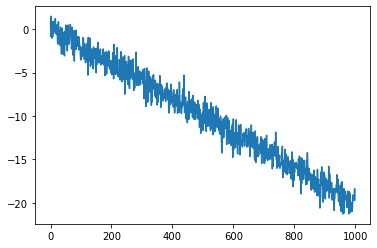

In [17]:
plt.plot(np.array([-x / 100 for x in range(0,2000,2)]) + np.random.randn(1000))

In [19]:
df1 = pd.DataFrame(
    {
        'y': np.array([x / 100 for x in range(0,2000,2)]) + np.random.randn(1000),
        'x': np.array([-x / 100 for x in range(0,2000,2)]) + np.random.randn(1000),
        'date': pd.date_range("01/01/2015", periods=1000)
    }
)
df1.head()

,y,x,date
0,-2.655935,0.783420,2015-01-01
1,-0.833819,0.605050,2015-01-02
2,1.711064,0.875710,2015-01-03
3,0.464045,0.405894,2015-01-04
4,1.686834,-2.607113,2015-01-05


In [20]:
df2 = pd.DataFrame(
    {
        'y': np.array([x / 100 for x in range(2000,4000,2)]) + np.random.randn(1000),
        'x': np.array([-x / 100 for x in range(2000,4000,2)]) + np.random.randn(1000),
        'date': pd.date_range("01/01/2019", periods=1000)
    }
)
df2.head()

,y,x,date
0,20.451426,-19.897939,2019-01-01
1,20.696856,-20.517522,2019-01-02
2,19.590346,-19.998876,2019-01-03
3,17.202566,-19.211234,2019-01-04
4,19.874523,-19.621572,2019-01-05


In [21]:
df1.to_csv('../data/test/csv1.csv', index=False)

In [22]:
df2.to_csv('../data/test/csv2.csv', index=False)

#### Read CSVs into Dask Dataframe

In [23]:
ddf = dd.read_csv('../data/test/csv*.csv', parse_dates=['date']).set_index('date')
ddf

,y,x
npartitions=2,,
2015-01-01,float64,float64
2019-01-01,...,...
2021-09-26,...,...


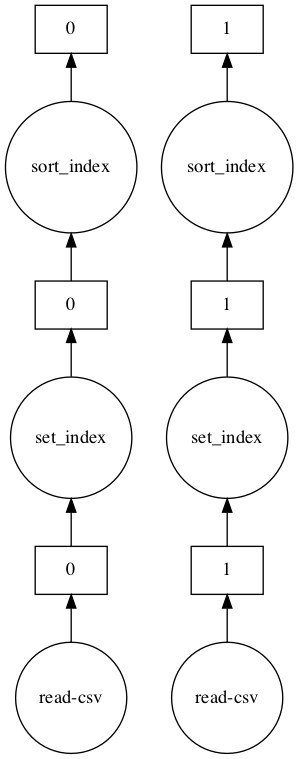

In [24]:
ddf.visualize()

In [25]:
ddf2 = ddf.loc[(ddf.index > pd.Timestamp("2017-01-01")) & (ddf.index < pd.Timestamp("2020-12-31"))]

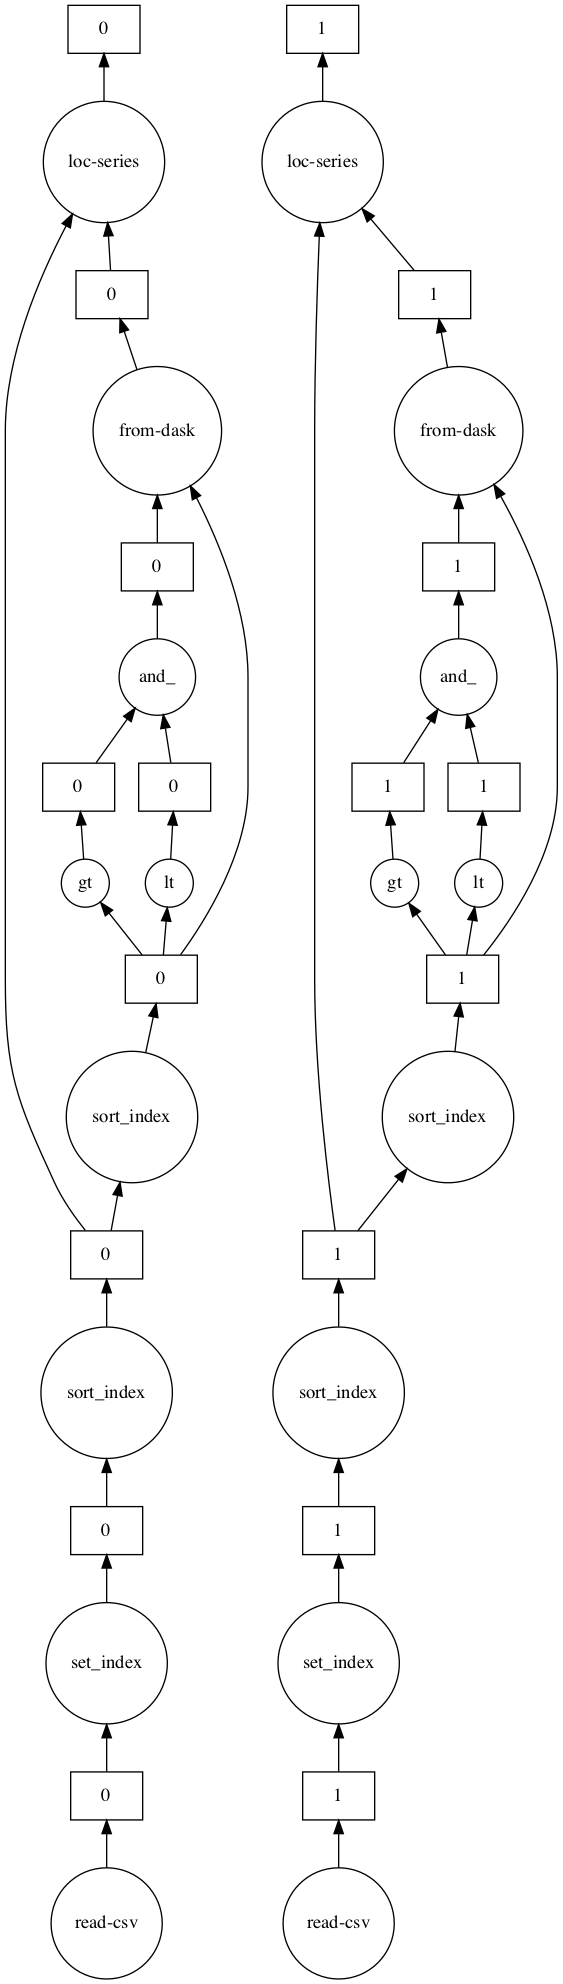

In [26]:
ddf2.visualize()

In [27]:
ddf2.compute()

,y,x
date,,
2017-01-02,14.776352,-14.506825
2017-01-03,14.851331,-14.990344
2017-01-04,15.852713,-16.507092
2017-01-05,14.110462,-14.012206
2017-01-06,13.412328,-14.396822
...,...,...
2020-12-26,34.444798,-33.882145
2020-12-27,32.265590,-35.073817
2020-12-28,34.096401,-35.049437


#### Machine learning

##### Basic train-test split

In [29]:
from dask_ml.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(ddf.x, ddf.y, shuffle=False)

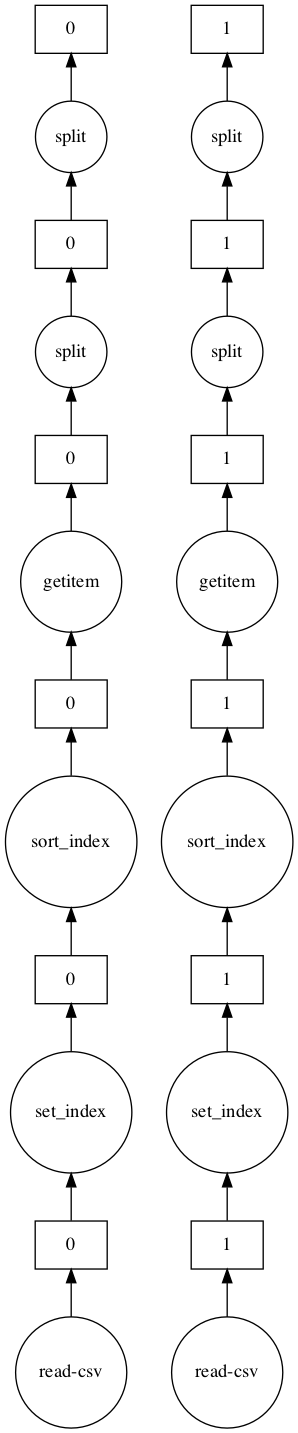

In [32]:
X_train.visualize()

##### Time series split

In [33]:
from dask_ml.wrappers import Incremental
from sklearn.linear_model import SGDRegressor

In [36]:
from sklearn.metrics import mean_squared_error

In [176]:
estimator = SGDRegressor(fit_intercept=True)
# clf = Incremental(estimator, shuffle_blocks=False, assume_equal_chunks=False)
clf = Incremental(estimator)

In [177]:
clf.get_params()

{'assume_equal_chunks': True,
 'estimator__alpha': 0.0001,
 'estimator__average': False,
 'estimator__early_stopping': False,
 'estimator__epsilon': 0.1,
 'estimator__eta0': 0.01,
 'estimator__fit_intercept': True,
 'estimator__l1_ratio': 0.15,
 'estimator__learning_rate': 'invscaling',
 'estimator__loss': 'squared_loss',
 'estimator__max_iter': 1000,
 'estimator__n_iter_no_change': 5,
 'estimator__penalty': 'l2',
 'estimator__power_t': 0.25,
 'estimator__random_state': None,
 'estimator__shuffle': True,
 'estimator__tol': 0.001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': SGDRegressor(),
 'random_state': None,
 'scoring': None,
 'shuffle_blocks': True}

In [131]:
def time_train_test_split(data):
    return (data.loc[(data.index <= pd.Timestamp('2017-12-31'))].repartition(freq='1m'), 
            data.loc[(data.index > pd.Timestamp('2017-12-31'))].repartition(freq='1m'))

# ddf.loc[(ddf.index > pd.Timestamp("2017-01-01")) & (ddf.index < pd.Timestamp("2020-12-31"))]

In [159]:
# trainX.to_dask_array(lengths=[500,500]).reshape(-1,1)

In [160]:
# from dask_ml.datasets import make_classification
# from sklearn.linear_model import SGDClassifier

# X, y = make_classification(chunks=25)
# y

In [161]:
# estimat = SGDClassifier(random_state=10, max_iter=100)

# clf_class = Incremental(estimat)

# clf_class.fit(X, y, classes=[0, 1])

In [130]:
trainX.repartition(freq='1m').map_partitions(len).compute()

0     30
1     28
2     31
3     30
4     31
      ..
76     0
77     0
78     0
79     0
80     0
Length: 81, dtype: int64

In [138]:
def cull_empty_partitions(df):
    ll = list(df.map_partitions(len).compute())
    df_delayed = df.to_delayed()
    df_delayed_new = list()
    pempty = None
    for ix, n in enumerate(ll):
        if 0 == n:
            pempty = df.get_partition(ix)
        else:
            df_delayed_new.append(df_delayed[ix])
    if pempty is not None:
        df = dd.from_delayed(df_delayed_new, meta=pempty)
    return df

In [166]:
# trainX = cull_empty_partitions(trainX)
# tuple(trainX.map_partitions(len).compute())

In [167]:
# trainX.npartitions

In [141]:
trainy = cull_empty_partitions(trainy)
tuple(trainy.map_partitions(len).compute())

(30,
 28,
 31,
 30,
 31,
 30,
 31,
 31,
 30,
 31,
 30,
 31,
 31,
 29,
 31,
 30,
 31,
 30,
 31,
 31,
 30,
 31,
 30,
 31,
 31,
 28,
 31,
 30,
 31,
 30,
 31,
 31,
 27)

In [143]:
for p in range(trainX.npartitions):
    print(f"Partition Index={p}, Number of Rows={len(trainX.get_partition(p))}")

Partition Index=0, Number of Rows=30
Partition Index=1, Number of Rows=28
Partition Index=2, Number of Rows=31
Partition Index=3, Number of Rows=30
Partition Index=4, Number of Rows=31
Partition Index=5, Number of Rows=30
Partition Index=6, Number of Rows=31
Partition Index=7, Number of Rows=31
Partition Index=8, Number of Rows=30
Partition Index=9, Number of Rows=31
Partition Index=10, Number of Rows=30
Partition Index=11, Number of Rows=31
Partition Index=12, Number of Rows=31
Partition Index=13, Number of Rows=29
Partition Index=14, Number of Rows=31
Partition Index=15, Number of Rows=30
Partition Index=16, Number of Rows=31
Partition Index=17, Number of Rows=30
Partition Index=18, Number of Rows=31
Partition Index=19, Number of Rows=31
Partition Index=20, Number of Rows=30
Partition Index=21, Number of Rows=31
Partition Index=22, Number of Rows=30
Partition Index=23, Number of Rows=31
Partition Index=24, Number of Rows=31
Partition Index=25, Number of Rows=28
Partition Index=26, Nu

In [162]:
# chunks = tuple(trainX.map_partitions(len).compute())
# chunks

In [163]:
# size = sum(chunks)
# size

In [164]:
# type(trainX)
# a = trainX.values
# a

In [165]:
# arr = da.Array(a.dask, a.name, chunks, a.dtype, (size,))

In [135]:
trainX.to_dask_array(lengths=True).reshape(-1,1)

dask.array<reshape, shape=(1000, 1), dtype=float64, chunksize=(31, 1), chunktype=numpy.ndarray>

In [136]:
# trainy.to_dask_array(lengths=[500,500])
trainy.to_dask_array(lengths=True)

dask.array<values, shape=(1000,), dtype=float64, chunksize=(31,), chunktype=numpy.ndarray>

In [178]:
train, test = time_train_test_split(ddf)

trainX = train['x']
trainX = cull_empty_partitions(trainX)
trainy = train['y']
trainy = cull_empty_partitions(trainy)

# type(trainX.to_frame())
# clf.fit(trainX.to_dask_array(lengths=[500,500]).reshape(-1, 1), trainy.to_dask_array(lengths=[500,500]))
clf.fit(trainX.to_dask_array(lengths=True).reshape(-1, 1), trainy.to_dask_array(lengths=True))

Incremental(estimator=SGDRegressor())

In [179]:
# clf.predict(cull_empty_partitions(test)).compute()
clf.coef_

array([-0.93042226])

In [181]:
test = cull_empty_partitions(test)
test.npartitions
tuple(test.map_partitions(len).compute())

(30,
 28,
 31,
 30,
 31,
 30,
 31,
 31,
 30,
 31,
 30,
 31,
 31,
 29,
 31,
 30,
 31,
 30,
 31,
 31,
 30,
 31,
 30,
 31,
 31,
 28,
 31,
 30,
 31,
 30,
 31,
 31,
 27)

In [183]:
clf.predict(test['x'].to_dask_array(lengths=True).reshape(-1, 1)).compute()[:10]

array([18.99690485, 19.57337866, 19.0908192 , 18.35797935, 18.73976724,
       18.75589571, 19.07941654, 18.37840143, 18.78457924, 19.67177445])

In [186]:
clf.score(trainX.to_dask_array(lengths=True).reshape(-1, 1), trainy.to_dask_array(lengths=True))

0.9427326100176773

In [187]:
clf.intercept_

array([0.48341973])

In [173]:
# trainX.npartitions

In [174]:
# trainX.divisions

In [175]:
# ddf.npartitions

In [ ]:
def walk_forward_validation(data):
    predictions = []
    train, test = time_train_test_split(ddf)
    for in range(len(test)):
        testX, testy = test['x'], test['y']
        yhat = sgd_reg(, testX)
        predictions.append(yhat)

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 
# load the dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()